<a href="https://colab.research.google.com/github/groda/big_data/blob/master/Apache_Sedona_with_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# Apache Sedona with PySpark

Apache Sedona™ is a prime example of a distributed engine built on top of Spark, specifically designed for geographic data processing.

The home page describes Apache Sedona ([https://sedona.apache.org/](https://sedona.apache.org/)) as:

> *a cluster computing system for processing large-scale spatial data. Sedona extends existing cluster computing systems, such as Apache Spark, Apache Flink, and Snowflake, with a set of out-of-the-box distributed Spatial Datasets and Spatial SQL that efficiently load, process, and analyze large-scale spatial data across machines.*

In this notebook we are going to execute a basic Sedona demonstration using PySpark. The Sedona notebook starts below at [Apache Sedona Core demo](#scrollTo=Apache_Sedona_Core_demo).



## Install Apache Sedona, PySpark, and required libraries

To start with, we are going to install `apache-sedona` and PySpark making sure that we have the desired Spark version.


The required packages are specified in this [Pipfile](https://github.com/apache/sedona/blob/master/python/Pipfile) under `[packages]`:

```
[packages]
pandas="<=1.5.3"
geopandas="*"
numpy="<2"
shapely=">=1.7.0"
pyspark=">=2.3.0"
attrs="*"
pyarrow="*"
keplergl = "==0.3.2"
pydeck = "===0.8.0"
rasterio = ">=1.2.10"
```

Install Apache Sedona without Spark. To install Spark as well you can use `pip install apache-sedona[spark]` but we chose to use the Spark engine that comes with PySpark.

In [1]:
!pip install apache-sedona

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 47.8 MB/s eta 0:00:00


For the sake of this tutorial we are going to use the Spark engine that is included in the Pyspark distribution. Since Sedona needs Spark $3.4.0$ we need to make sure that we choose the correct PySpark version.

In [2]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317122 sha256=a9fedbd98a96219bc47440f5623d2e369722deb395e1730ccbf4fdc09804c329
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


Verify that PySpark is using Spark version $3.4.0$.

In [3]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.4.0
      /_/
                        
Using Scala version 2.12.17, OpenJDK 64-Bit Server VM, 11.0.24
Branch HEAD
Compiled by user xinrong.meng on 2023-04-07T02:18:01Z
Revision 87a5442f7ed96b11051d8a9333476d080054e5a0
Url https://github.com/apache/spark
Type --help for more information.


### Install Geopandas

The libraries `numpy`, `pandas`, `geopandas`, and `shapely` are available by default on Google Colab.

In [4]:
!pip install geopandas

In [5]:
!pip install shapely

## Download the data

We are going to download the data from Sedona's GitHub repository.

In [6]:
import json
import os
import urllib
import base64

def download_blob(url, path, localfile):
    print(f"Downloading blob to localfile: {localfile} from {url}")

    # Fetch the JSON data from the URL
    with urllib.request.urlopen(url) as response:
        json_data = response.read().decode('utf-8')

        # Load the JSON data into a dictionary
        data = json.loads(json_data)

        # Extract the Base64 content
        base64_content = data['content']

        # Decode the Base64 content
        decoded_content = base64.b64decode(base64_content)

        try:
            # Attempt to decode as UTF-8 text
            decoded_text = decoded_content.decode('utf-8')
            with open(localfile, 'w') as f:
                f.write(decoded_text)
        except UnicodeDecodeError:
            # If text decoding fails, save as binary
            with open(localfile, 'wb') as f:
                f.write(decoded_content)


def download_gitpath(url, path, localpath):
    """
    Recursively downloads a specific path (directory or file) from a GitHub repository using the GitHub API
    and saves it to a specified local directory, preserving the repository's structure.

    Args:
        url (str):
            The GitHub API URL that points to the tree structure of the repository.
            This URL should provide a JSON response containing the file and directory information for the tree.

        path (str):
            The path within the repository that you want to download.
            This path is used to filter the relevant files and directories within the tree structure.
            Example: "src/utils" would download everything under the `src/utils` directory in the repository.

        localpath (str):
            The local directory path where the downloaded files and directories will be saved.
            If the directory does not exist, it will be created. The repository's structure will be mirrored in this location.

    Returns:
        None

    Example:
        tree_url = "https://api.github.com/repos/{owner}/{repo_name}/git/trees/master?recursive=true"
        tree_url = "https://api.github.com/repos/apache/spark/git/trees/master?recursive=true"
        repo_path = "data/mllib/images"
        local_dir = "./downloaded_images"

        download_gitpath(tree_url, repo_path, local_dir)

    How it works:
        1. The function fetches the tree of files and directories from the GitHub API using the provided URL.
        2. It filters the tree data to only include items that fall under the specified `path`.
        3. Files (blobs) are downloaded and saved locally.
        4. Directories (trees) are handled recursively by creating local directories and downloading their contents.

    Notes:
        - Ensure that you have access to the repository's GitHub API, especially if it's private (you may need a token).
        - This function will handle both text and binary files appropriately.
        - Error handling for network and API issues is minimal and could be enhanced.
    """
    #print(f"Processing path: {path} into local directory: {localpath}")

    # Create the local directory if it doesn't exist
    os.makedirs(localpath, exist_ok=True)

    with urllib.request.urlopen(url) as response:
        json_data = response.read().decode('utf-8')

        # Load the JSON data into a dictionary
        data = json.loads(json_data)['tree']

        # Filter and map the paths to their URLs
        items = {x['path']: (x['url'], x['type']) for x in data if x['path'].startswith(path)}

        for item_path, (item_url, item_type) in items.items():

            # Handle blobs (files)
            if item_type == 'blob':
                local_file_path = os.path.join(localpath, os.path.relpath(item_path, path))
                download_blob(item_url, item_path, local_file_path)

            # Handle trees (directories)
            elif item_type == 'tree':
                new_local_dir = os.path.join(localpath, os.path.relpath(item_path, path))
                os.makedirs(new_local_dir, exist_ok=True)
                download_gitpath(item_url, item_path, new_local_dir)


In [7]:
url = 'https://api.github.com/repos/jiayuasu/sedona/git/trees/master?recursive=true'
path = 'docs/usecases/data/'
# download only if data folder does not exist
if not os.path.exists('./data'):
  os.makedirs('./data')
  download_gitpath(url, path, './data')

Verify the presence of data in the designated `data` folder.

In [8]:
!ls -lR data

data:
total 16716
-rw-r--r-- 1 root root  200449 Oct 14 20:34 arealm-small.csv
-rw-r--r-- 1 root root 4182112 Oct 14 20:34 county_small.tsv
-rw-r--r-- 1 root root 6379960 Oct 14 20:34 county_small_wkb.tsv
-rw-r--r-- 1 root root       6 Oct 14 20:34 gis_osm_pois_free_1.cpg
-rw-r--r-- 1 root root 1841000 Oct 14 20:34 gis_osm_pois_free_1.dbf
-rw-r--r-- 1 root root     144 Oct 14 20:34 gis_osm_pois_free_1.prj
-rw-r--r-- 1 root root  360544 Oct 14 20:34 gis_osm_pois_free_1.shp
-rw-r--r-- 1 root root  103084 Oct 14 20:34 gis_osm_pois_free_1.shx
drwxr-xr-x 2 root root    4096 Oct 14 20:34 ne_50m_admin_0_countries_lakes
drwxr-xr-x 2 root root    4096 Oct 14 20:34 ne_50m_airports
drwxr-xr-x 2 root root    4096 Oct 14 20:34 polygon
-rw-r--r-- 1 root root 1132600 Oct 14 20:35 primaryroads-linestring.csv
-rw-r--r-- 1 root root 1399092 Oct 14 20:35 primaryroads-polygon.csv
drwxr-xr-x 2 root root    4096 Oct 14 20:35 raster
-rw-r--r-- 1 root root   12993 Oct 14 20:35 testpoint.csv
-rw-r--r-- 1 root 

# Apache Sedona Core demo

The notebook is available at the following link: https://github.com/apache/sedona/blob/master/docs/usecases/ApacheSedonaCore.ipynb.

Refer to https://mvnrepository.com/artifact/org.apache.sedona/sedona-spark-3.4 for making sense of packages and versions.




```
Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at
  http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.
```

In [9]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import geopandas as gpd
import pandas as pd
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import LongType
from shapely.geometry import Point
from shapely.geometry import Polygon

from sedona.spark import *
from sedona.core.geom.envelope import Envelope

Note: the next cell might take a while to execute. Stretch your legs and contemplate the mysteries of the universe in the meantime. Hang tight!

In [10]:
config = SedonaContext.builder() .\
    config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-3.4_2.12:1.6.0,'
           'org.datasyslab:geotools-wrapper:1.6.0-28.2,'
           'uk.co.gresearch.spark:spark-extension_2.12:2.11.0-3.4'). \
    getOrCreate()


sedona = SedonaContext.create(config)

In [11]:
sc = sedona.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

`config` is the Spark session

In [12]:
type(config)

pyspark.sql.session.SparkSession

# Create SpatialRDD

## Reading to PointRDD from CSV file

We now want load the CSV file into Apache Sedona PointRDD
```
testattribute0,-88.331492,32.324142,testattribute1,testattribute2
testattribute0,-88.175933,32.360763,testattribute1,testattribute2
testattribute0,-88.388954,32.357073,testattribute1,testattribute2
testattribute0,-88.221102,32.35078,testattribute1,testattribute2
testattribute0,-88.323995,32.950671,testattribute1,testattribute2
testattribute0,-88.231077,32.700812,testattribute1,testattribute2
```

In [13]:
!head data/arealm-small.csv

testattribute0,-88.331492,32.324142,testattribute1,testattribute2
testattribute0,-88.175933,32.360763,testattribute1,testattribute2
testattribute0,-88.388954,32.357073,testattribute1,testattribute2
testattribute0,-88.221102,32.35078,testattribute1,testattribute2
testattribute0,-88.323995,32.950671,testattribute1,testattribute2
testattribute0,-88.231077,32.700812,testattribute1,testattribute2
testattribute0,-88.349276,32.548266,testattribute1,testattribute2
testattribute0,-88.304259,32.488903,testattribute1,testattribute2
testattribute0,-88.182481,32.59966,testattribute1,testattribute2
testattribute0,-86.955186,32.617088,testattribute1,testattribute2


In [14]:
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, True, 10)

In [15]:
## Getting approximate total count
point_rdd.approximateTotalCount

3000

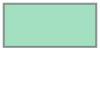

In [16]:
# getting boundary for PointRDD or any other SpatialRDD, it returns Enelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundary()

In [17]:
# To run analyze please use function analyze
point_rdd.analyze()

True

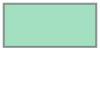

In [18]:
# Finding boundary envelope for PointRDD or any other SpatialRDD, it returns Enelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundaryEnvelope

In [19]:
# Calculate number of records without duplicates
point_rdd.countWithoutDuplicates()

2996

In [20]:
# Getting source epsg code
point_rdd.getSourceEpsgCode()

''

In [21]:
# Getting target epsg code
point_rdd.getTargetEpsgCode()

''

In [22]:
# Spatial partitioning data
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

## Operations on RawSpatialRDD

rawSpatialRDD method returns RDD which consists of GeoData objects which has 2 attributes
<li> geom: shapely.geometry.BaseGeometry </li>
<li> userData: str </li>

You can use any operations on those objects and spread across machines

In [23]:
# take firs element
point_rdd.rawSpatialRDD.take(1)

[Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [24]:
# collect to Python list
point_rdd.rawSpatialRDD.collect()[:5]

[Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [25]:
# apply map functions, for example distance to Point(52 21)
point_rdd.rawSpatialRDD.map(lambda x: x.geom.distance(Point(21, 52))).take(5)

[111.08786851399313,
 110.92828303170774,
 111.1385974283527,
 110.97450594034112,
 110.97122518072091]

## Transforming to GeoPandas

## Loaded data can be transformed to GeoPandas DataFrame in a few ways

### Directly from RDD

In [26]:
point_rdd_to_geo = point_rdd.rawSpatialRDD.map(lambda x: [x.geom, *x.getUserData().split("\t")])

In [27]:
point_gdf = gpd.GeoDataFrame(
    point_rdd_to_geo.collect(), columns=["geom", "attr1", "attr2", "attr3"], geometry="geom"
)

In [28]:
point_gdf[:5]

,geom,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.2211 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.324 32.95067),testattribute0,testattribute1,testattribute2


### Using Adapter

In [29]:
# Adapter allows you to convert geospatial data types introduced with sedona to other ones

In [30]:
spatial_df = Adapter.\
    toDf(point_rdd, ["attr1", "attr2", "attr3"], sedona).\
    createOrReplaceTempView("spatial_df")

spatial_gdf = sedona.sql("Select attr1, attr2, attr3, geometry as geom from spatial_df")

In [31]:
spatial_gdf.show(5, False)

+--------------+--------------+--------------+----------------------------+
|attr1         |attr2         |attr3         |geom                        |
+--------------+--------------+--------------+----------------------------+
|testattribute0|testattribute1|testattribute2|POINT (-88.331492 32.324142)|
|testattribute0|testattribute1|testattribute2|POINT (-88.175933 32.360763)|
|testattribute0|testattribute1|testattribute2|POINT (-88.388954 32.357073)|
|testattribute0|testattribute1|testattribute2|POINT (-88.221102 32.35078) |
|testattribute0|testattribute1|testattribute2|POINT (-88.323995 32.950671)|
+--------------+--------------+--------------+----------------------------+
only showing top 5 rows



In [32]:
gpd.GeoDataFrame(spatial_gdf.toPandas(), geometry="geom")[:5]

,attr1,attr2,attr3,geom
0,testattribute0,testattribute1,testattribute2,POINT (-88.33149 32.32414)
1,testattribute0,testattribute1,testattribute2,POINT (-88.17593 32.36076)
2,testattribute0,testattribute1,testattribute2,POINT (-88.38895 32.35707)
3,testattribute0,testattribute1,testattribute2,POINT (-88.2211 32.35078)
4,testattribute0,testattribute1,testattribute2,POINT (-88.324 32.95067)


### With DataFrame creation

In [33]:
schema = StructType(
    [
        StructField("geometry", GeometryType(), False),
        StructField("attr1", StringType(), False),
        StructField("attr2", StringType(), False),
        StructField("attr3", StringType(), False),
    ]
)

In [34]:
geo_df = sedona.createDataFrame(point_rdd_to_geo, schema, verifySchema=False)

In [35]:
gpd.GeoDataFrame(geo_df.toPandas(), geometry="geometry")[:5]

,geometry,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.2211 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.324 32.95067),testattribute0,testattribute1,testattribute2


# Load Typed SpatialRDDs

Currently The library supports 5 typed SpatialRDDs:
<li> RectangleRDD </li>
<li> PointRDD </li>
<li> PolygonRDD </li>
<li> LineStringRDD </li>
<li> CircleRDD </li>

In [36]:
rectangle_rdd = RectangleRDD(sc, "data/zcta510-small.csv", FileDataSplitter.CSV, True, 11)
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, False, 11)
polygon_rdd = PolygonRDD(sc, "data/primaryroads-polygon.csv", FileDataSplitter.CSV, True, 11)
linestring_rdd = LineStringRDD(sc, "data/primaryroads-linestring.csv", FileDataSplitter.CSV, True)

In [37]:
rectangle_rdd.analyze()
point_rdd.analyze()
polygon_rdd.analyze()
linestring_rdd.analyze()

True

# Spatial Partitioning

Apache Sedona spatial partitioning method can significantly speed up the join query. Three spatial partitioning methods are available: KDB-Tree, Quad-Tree and R-Tree. Two SpatialRDD must be partitioned by the same way.

In [38]:
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

# Create Index

Apache Sedona provides two types of spatial indexes, Quad-Tree and R-Tree. Once you specify an index type, Apache Sedona will build a local tree index on each of the SpatialRDD partition.

In [39]:
point_rdd.buildIndex(IndexType.RTREE, True)

# SpatialJoin

Spatial join is operation which combines data based on spatial relations like:
<li> intersects </li>
<li> touches </li>
<li> within </li>
<li> etc </li>

To Use Spatial Join in GeoPyspark library please use JoinQuery object, which has implemented below methods:
```python
SpatialJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

DistanceJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

spatialJoin(queryWindowRDD: SpatialRDD, objectRDD: SpatialRDD, joinParams: JoinParams) -> RDD

DistanceJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

SpatialJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

```

## Example SpatialJoinQueryFlat PointRDD with RectangleRDD

In [40]:
# partitioning the data
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQuery.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

As result we will get RDD[GeoData, GeoData]
It can be used like any other Python RDD. You can use map, take, collect and other functions  

In [41]:
result

MapPartitionsRDD[63] at map at FlatPairRddConverter.scala:30

In [42]:
result.take(2)

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [43]:
result.collect()[:3]

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [44]:
# getting distance using SpatialObjects
result.map(lambda x: x[0].geom.distance(x[1].geom)).take(5)

[0.0, 0.0, 0.0, 0.0, 0.0]

In [45]:
# getting area of polygon data
result.map(lambda x: x[0].geom.area).take(5)

[0.026651558685001447,
 0.026651558685001447,
 0.026651558685001447,
 0.057069904940998895,
 0.057069904940998895]

In [46]:
# Base on result you can create DataFrame object, using map function and build DataFrame from RDD
schema = StructType(
    [
        StructField("geom_left", GeometryType(), False),
        StructField("geom_right", GeometryType(), False)
    ]
)

In [47]:
# Set verifySchema to False
spatial_join_result = result.map(lambda x: [x[0].geom, x[1].geom])
sedona.createDataFrame(spatial_join_result, schema, verifySchema=False).show(5, True)

+--------------------+--------------------+
|           geom_left|          geom_right|
+--------------------+--------------------+
|POLYGON ((-87.229...|POINT (-87.204033...|
|POLYGON ((-87.229...|POINT (-87.204299...|
|POLYGON ((-87.229...|POINT (-87.19351 ...|
|POLYGON ((-87.285...|POINT (-87.28468 ...|
|POLYGON ((-87.285...|POINT (-87.215491...|
+--------------------+--------------------+
only showing top 5 rows



In [48]:
# Above code produces DataFrame with geometry Data type
sedona.createDataFrame(spatial_join_result, schema, verifySchema=False).printSchema()

root
 |-- geom_left: geometry (nullable = false)
 |-- geom_right: geometry (nullable = false)



We can create DataFrame object from Spatial Pair RDD using Adapter object as follows

In [49]:
Adapter.toDf(result, ["attr1"], ["attr2"], sedona).show(5, True)

+--------------------+-----+--------------------+-----+
|              geom_1|attr1|              geom_2|attr2|
+--------------------+-----+--------------------+-----+
|POLYGON ((-87.229...|     |POINT (-87.204033...|     |
|POLYGON ((-87.229...|     |POINT (-87.204299...|     |
|POLYGON ((-87.229...|     |POINT (-87.19351 ...|     |
|POLYGON ((-87.285...|     |POINT (-87.28468 ...|     |
|POLYGON ((-87.285...|     |POINT (-87.215491...|     |
+--------------------+-----+--------------------+-----+
only showing top 5 rows



This also produce DataFrame with geometry DataType

In [50]:
Adapter.toDf(result, ["attr1"], ["attr2"], sedona).printSchema()

root
 |-- geom_1: geometry (nullable = true)
 |-- attr1: string (nullable = true)
 |-- geom_2: geometry (nullable = true)
 |-- attr2: string (nullable = true)



We can create RDD which will be of type RDD[GeoData, List[GeoData]]
We can for example calculate number of Points within some polygon data

To do that we can use code specified below

In [51]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())

In [52]:
spatial_join_result_non_flat = JoinQuery.SpatialJoinQuery(point_rdd, rectangle_rdd, False, True)

In [53]:
# number of point for each polygon
number_of_points = spatial_join_result_non_flat.map(lambda x: [x[0].geom, x[1].__len__()])

In [54]:
schema = StructType([
    StructField("geometry", GeometryType(), False),
    StructField("number_of_points", LongType(), False)
])

In [55]:
sedona.createDataFrame(number_of_points, schema, verifySchema=False).show()

+--------------------+----------------+
|            geometry|number_of_points|
+--------------------+----------------+
|POLYGON ((-86.749...|               4|
|POLYGON ((-87.082...|              12|
|POLYGON ((-86.697...|               1|
|POLYGON ((-87.105...|              15|
|POLYGON ((-87.114...|              15|
|POLYGON ((-87.229...|               7|
|POLYGON ((-86.860...|              12|
|POLYGON ((-86.816...|               6|
|POLYGON ((-87.092...|               5|
|POLYGON ((-87.285...|              26|
+--------------------+----------------+



# KNNQuery

Spatial KNNQuery is operation which help us find answer which k number of geometries lays closest to other geometry.

For Example:
    5 closest Shops to your home. To use Spatial KNNQuery please use object
<b> KNNQuery </b> which has one method:
```python
SpatialKnnQuery(spatialRDD: SpatialRDD, originalQueryPoint: BaseGeometry, k: int,  useIndex: bool)-> List[GeoData]
```

### Finds 5 closest points from PointRDD to given Point

In [56]:
result = KNNQuery.SpatialKnnQuery(point_rdd, Point(-84.01, 34.01), 5, False)

In [57]:
result

[Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ]

As Reference geometry you can also use Polygon or LineString object

In [58]:
polygon = Polygon(
    [(-84.237756, 33.904859), (-84.237756, 34.090426),
     (-83.833011, 34.090426), (-83.833011, 33.904859),
     (-84.237756, 33.904859)
    ])
polygons_nearby = KNNQuery.SpatialKnnQuery(polygon_rdd, polygon, 5, False)

In [59]:
polygons_nearby

[Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ]

In [60]:
polygons_nearby[0].geom.wkt

'POLYGON ((-83.993559 34.087259, -83.993559 34.131247, -83.959903 34.131247, -83.959903 34.087259, -83.993559 34.087259))'

# RangeQuery

A spatial range query takes as input a range query window and an SpatialRDD and returns all geometries that intersect / are fully covered by the query window.
RangeQuery has one method:

```python
SpatialRangeQuery(self, spatialRDD: SpatialRDD, rangeQueryWindow: BaseGeometry, considerBoundaryIntersection: bool, usingIndex: bool) -> RDD
```

In [61]:
from sedona.core.geom.envelope import Envelope

In [62]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQuery.SpatialRangeQuery(linestring_rdd, query_envelope, False, False)

In [63]:
result_range_query

MapPartitionsRDD[122] at map at GeometryRddConverter.scala:30

In [64]:
result_range_query.take(6)

[Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ]

In [65]:
# Creating DataFrame from result

In [66]:
schema = StructType([StructField("geometry", GeometryType(), False)])

In [67]:
sedona.createDataFrame(
    result_range_query.map(lambda x: [x.geom]),
    schema,
    verifySchema=False
).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



# Load From other Formats

GeoPyspark allows to load the data from other Data formats like:
<li> GeoJSON </li>
<li> Shapefile </li>
<li> WKB </li>
<li> WKT </li>

## ShapeFile - load to SpatialRDD

In [68]:
shape_rdd = ShapefileReader.readToGeometryRDD(sc, "data/polygon")

In [69]:
shape_rdd

In [70]:
Adapter.toDf(shape_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|MULTIPOLYGON (((1...|
|MULTIPOLYGON (((-...|
|MULTIPOLYGON (((1...|
|POLYGON ((118.362...|
|MULTIPOLYGON (((-...|
+--------------------+
only showing top 5 rows



## GeoJSON - load to SpatialRDD

```
{ "type": "Feature", "properties": { "STATEFP": "01", "COUNTYFP": "077", "TRACTCE": "011501", "BLKGRPCE": "5", "AFFGEOID": "1500000US010770115015", "GEOID": "010770115015", "NAME": "5", "LSAD": "BG", "ALAND": 6844991, "AWATER": 32636 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -87.621765, 34.873444 ], [ -87.617535, 34.873369 ], [ -87.6123, 34.873337 ], [ -87.604049, 34.873303 ], [ -87.604033, 34.872316 ], [ -87.60415, 34.867502 ], [ -87.604218, 34.865687 ], [ -87.604409, 34.858537 ], [ -87.604018, 34.851336 ], [ -87.603716, 34.844829 ], [ -87.603696, 34.844307 ], [ -87.603673, 34.841884 ], [ -87.60372, 34.841003 ], [ -87.603879, 34.838423 ], [ -87.603888, 34.837682 ], [ -87.603889, 34.83763 ], [ -87.613127, 34.833938 ], [ -87.616451, 34.832699 ], [ -87.621041, 34.831431 ], [ -87.621056, 34.831526 ], [ -87.62112, 34.831925 ], [ -87.621603, 34.8352 ], [ -87.62158, 34.836087 ], [ -87.621383, 34.84329 ], [ -87.621359, 34.844438 ], [ -87.62129, 34.846387 ], [ -87.62119, 34.85053 ], [ -87.62144, 34.865379 ], [ -87.621765, 34.873444 ] ] ] } },
```

In [71]:
geo_json_rdd = GeoJsonReader.readToGeometryRDD(sc, "data/testPolygon.json")

In [72]:
geo_json_rdd

In [73]:
Adapter.toDf(geo_json_rdd, sedona).drop("AWATER").show(5, True)

+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|            geometry|STATEFP|COUNTYFP|TRACTCE|BLKGRPCE|            AFFGEOID|       GEOID|NAME|LSAD|   ALAND|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|POLYGON ((-87.621...|     01|     077| 011501|       5|1500000US01077011...|010770115015|   5|  BG| 6844991|
|POLYGON ((-85.719...|     01|     045| 021102|       4|1500000US01045021...|010450211024|   4|  BG|11360854|
|POLYGON ((-86.000...|     01|     055| 001300|       3|1500000US01055001...|010550013003|   3|  BG| 1378742|
|POLYGON ((-86.574...|     01|     089| 001700|       2|1500000US01089001...|010890017002|   2|  BG| 1040641|
|POLYGON ((-85.382...|     01|     069| 041400|       1|1500000US01069041...|010690414001|   1|  BG| 8243574|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
only showi

## WKT - loading to SpatialRDD

In [74]:
wkt_rdd = WktReader.readToGeometryRDD(sc, "data/county_small.tsv", 0, True, False)

In [75]:
wkt_rdd

In [76]:
Adapter.toDf(wkt_rdd, sedona).printSchema()

root
 |-- geometry: geometry (nullable = true)



In [77]:
Adapter.toDf(wkt_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



## WKB - load to SpatialRDD

In [78]:
wkb_rdd = WkbReader.readToGeometryRDD(sc, "data/county_small_wkb.tsv", 0, True, False)

In [79]:
Adapter.toDf(wkb_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



## Converting RDD Spatial join result to DF directly, avoiding jvm python serde

In [80]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQueryRaw.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

In [81]:
# without passing column names, the result will contain only two geometries columns
geometry_df = Adapter.toDf(result, sedona)

In [82]:
geometry_df.printSchema()

root
 |-- leftgeometry: geometry (nullable = true)
 |-- rightgeometry: geometry (nullable = true)



In [83]:
geometry_df.show(5)

+--------------------+--------------------+
|        leftgeometry|       rightgeometry|
+--------------------+--------------------+
|POLYGON ((-86.749...|POINT (-86.736302...|
|POLYGON ((-86.749...|POINT (-86.735506...|
|POLYGON ((-87.229...|POINT (-87.105455...|
|POLYGON ((-87.229...|POINT (-87.10534 ...|
|POLYGON ((-87.229...|POINT (-87.160372...|
+--------------------+--------------------+
only showing top 5 rows



In [84]:
geometry_df.collect()[0]

Row(leftgeometry=<POLYGON ((-86.749 34.495, -86.749 34.589, -86.635 34.589, -86.635 34.495, -...>, rightgeometry=<POINT (-86.736 34.583)>)

## Passing column names

In [85]:
geometry_df = Adapter.toDf(result, ["left_user_data"], ["right_user_data"], sedona)

In [86]:
geometry_df.show(5)

+--------------------+--------------+--------------------+---------------+
|        leftgeometry|left_user_data|       rightgeometry|right_user_data|
+--------------------+--------------+--------------------+---------------+
|POLYGON ((-86.749...|              |POINT (-86.736302...|           null|
|POLYGON ((-86.749...|              |POINT (-86.735506...|           null|
|POLYGON ((-87.229...|              |POINT (-87.105455...|           null|
|POLYGON ((-87.229...|              |POINT (-87.10534 ...|           null|
|POLYGON ((-87.229...|              |POINT (-87.160372...|           null|
+--------------------+--------------+--------------------+---------------+
only showing top 5 rows



# Converting RDD Spatial join result to DF directly, avoiding jvm python serde

In [87]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQueryRaw.SpatialRangeQuery(linestring_rdd, query_envelope, False, False)

In [88]:
# converting to df
gdf = Adapter.toDf(result_range_query, sedona)

In [89]:
gdf.show(5)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



In [90]:
gdf.printSchema()

root
 |-- geometry: geometry (nullable = true)



In [91]:
# Passing column names
# converting to df
gdf_with_columns = Adapter.toDf(result_range_query, sedona, ["_c1"])

In [92]:
gdf_with_columns.show(5)

+--------------------+---+
|            geometry|_c1|
+--------------------+---+
|LINESTRING (-72.1...|   |
|LINESTRING (-72.4...|   |
|LINESTRING (-72.4...|   |
|LINESTRING (-73.4...|   |
|LINESTRING (-73.6...|   |
+--------------------+---+
only showing top 5 rows



In [93]:
gdf_with_columns.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- _c1: string (nullable = true)



# Summary

We have shown how to install Sedona with Pyspark and run a basic example (source: https://github.com/apache/sedona/blob/master/docs/usecases/ApacheSedonaCore.ipynb) on Google Colab. This demo uses the Spark engine provided by PySpark.